In [1]:
import numpy as np
#import mlflow
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet_benchmark.AutoUnet_benchmark import *
from NN_library.AutoUnet_benchmark.train_AutoUnet_benchmark import *
%load_ext autoreload
%autoreload 2

#mlflow.autolog()

Using device: cuda


Test U-Net

In [2]:
data = dataset_seq()
loaders = get_loaders(data, 1)

In [3]:
name = 'NN_library/AutoUnet_benchmark/AutoUnet_benchmark_x2'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
unet = AutoUNet(128)
unet = load_network(unet, args['name'], args)

In [4]:
L_dam, L_shr, L_stiff = test(unet, loaders, args)
L_dam = np.array(L_dam)
L_shr = np.array(L_shr)
L_stiff = np.array(L_stiff)

In [5]:
dam_mean = L_dam.sum(axis=1).mean()
dam_std = L_dam.sum(axis=1).std()
shr_mean = L_shr.sum(axis=1).mean()
shr_std = L_shr.sum(axis=1).std()
stiff_mean = L_stiff.sum(axis=1).mean()
stiff_std = L_stiff.sum(axis=1).std()
print(dam_mean, '\n', dam_std)
print(shr_mean, '\n', shr_std)
print(stiff_mean, '\n', stiff_std)

20600.402 
 2696.7998
2445.3406 
 1489.5731
0.00021962968 
 0.00010349336


In [6]:
dam_mean = np.mean(L_dam, axis=0)
dam_std = np.std(L_dam, axis=0)
shr_mean = np.mean(L_shr, axis=0)
shr_std = np.std(L_shr, axis=0)
stiff_mean = np.mean(L_stiff, axis=0)
stiff_std = np.std(L_stiff, axis=0)

In [7]:
print(dam_mean, '\n', dam_std)
print(shr_mean, '\n', shr_std)
print(stiff_mean, '\n', stiff_std)

[1.4368208e-03 3.8848013e+02 1.1851486e+03 1.8149105e+03 2.2662639e+03
 2.5913958e+03 2.8344951e+03 3.0247920e+03 3.1807307e+03 3.3141799e+03] 
 [1.8979726e-02 1.0927261e+02 2.5302724e+02 3.2700647e+02 3.4930740e+02
 3.5350604e+02 3.5179544e+02 3.4974280e+02 3.4815912e+02 3.4703049e+02]
[  0.89327604  32.93878    161.72379    269.3235     312.77243
 327.4863     336.54007    334.91278    334.21155    334.53857   ] 
 [  0.6335227  29.51451   165.22131   231.4086    260.3098    289.16507
 306.045     291.1165    294.3641    317.04877  ]
[9.4646214e-07 2.6843502e-06 5.2478090e-06 8.7515518e-06 1.4006246e-05
 2.0849873e-05 2.4090044e-05 2.8621142e-05 4.3035787e-05 7.1396498e-05] 
 [7.4711568e-07 2.0439415e-06 4.2593492e-06 7.2706271e-06 1.0399344e-05
 1.4207126e-05 1.6904622e-05 2.2938884e-05 3.4062028e-05 4.4686505e-05]


Text(0, 0.5, 'Stiffness loss')

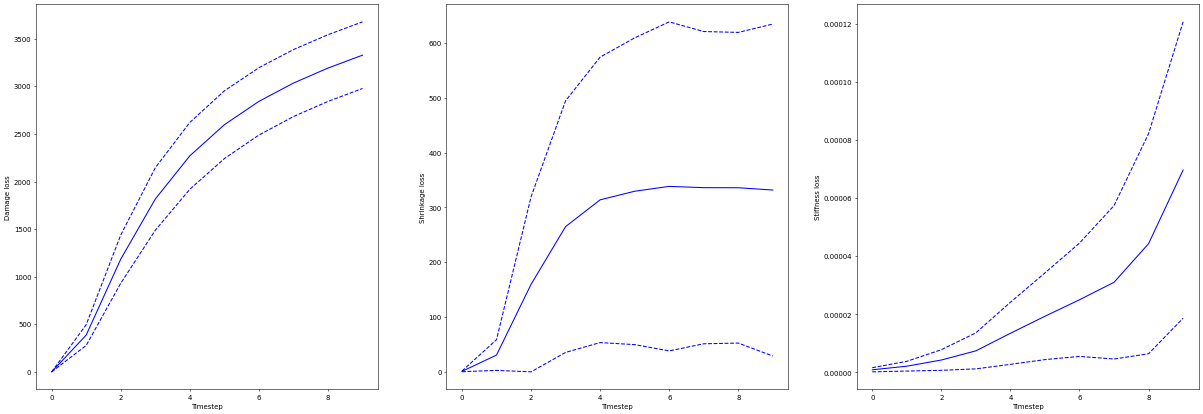

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), dpi=50)

axs.flat[0].plot(dam_mean, 'b')
axs.flat[0].plot(dam_mean+dam_std, 'b--')
axs.flat[0].plot(dam_mean-dam_std, 'b--')
axs.flat[0].set_xlabel('Timestep')
axs.flat[0].set_ylabel('Damage loss')

axs.flat[1].plot(shr_mean, 'b')
axs.flat[1].plot(shr_mean+shr_std, 'b--')
axs.flat[1].plot(shr_mean-shr_std, 'b--')
axs.flat[1].set_xlabel('Timestep')
axs.flat[1].set_ylabel('Shrinkage loss')

axs.flat[2].plot(stiff_mean, 'b')
axs.flat[2].plot(stiff_mean+stiff_std, 'b--')
axs.flat[2].plot(stiff_mean-stiff_std, 'b--')
axs.flat[2].set_xlabel('Timestep')
axs.flat[2].set_ylabel('Stiffness loss')

In [11]:
geometry, damage, imp_shrinkage, obs_shrinkage, stiffness = next(iter(loaders['test']))
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
obs_shrinkage = obs_shrinkage.to(args['dev'])
stiffness = stiffness.to(args['dev'])

In [12]:
unet = unet.to(args['dev'])

In [13]:
seq_test_dam = []
seq_test_stiff = []
seq_test_shr = []

for n in range(10):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:]], axis=1)
    else:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y[:,[0],:,:].detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach().cpu())
    seq_test_stiff.append(y[0,1].detach().cpu())
    seq_test_shr.append(y[0,2].detach().cpu())   

RuntimeError: Given groups=1, weight of size [64, 5, 3, 3], expected input[1, 3, 100, 100] to have 5 channels, but got 3 channels instead

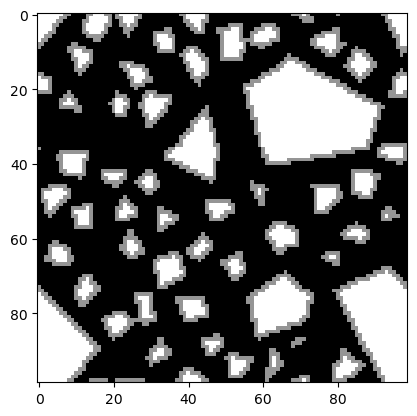

In [44]:
plt.imshow(geometry[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)

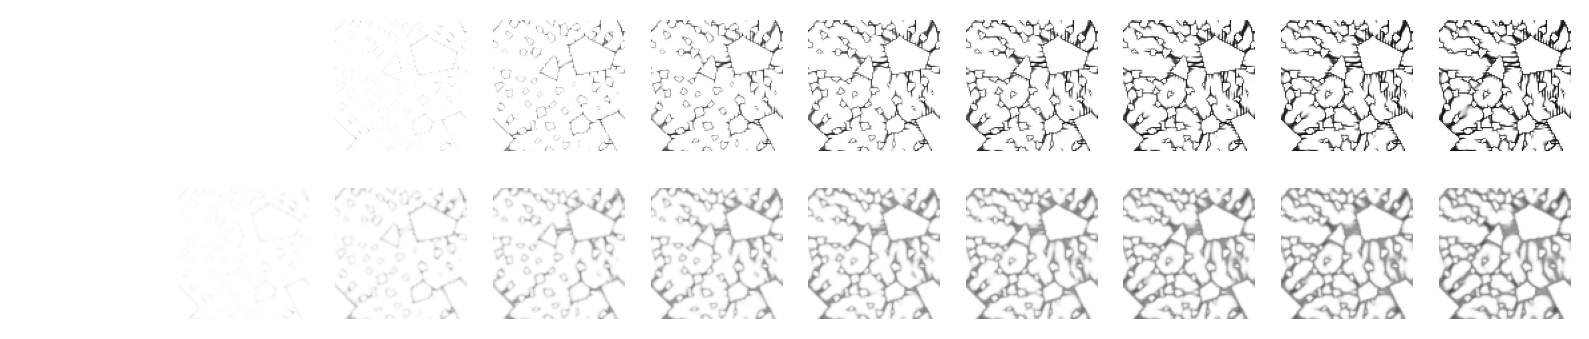

In [22]:
n_samples = 10
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow(damage[0, i].cpu().detach().cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_dam[i-n_samples].cpu(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()

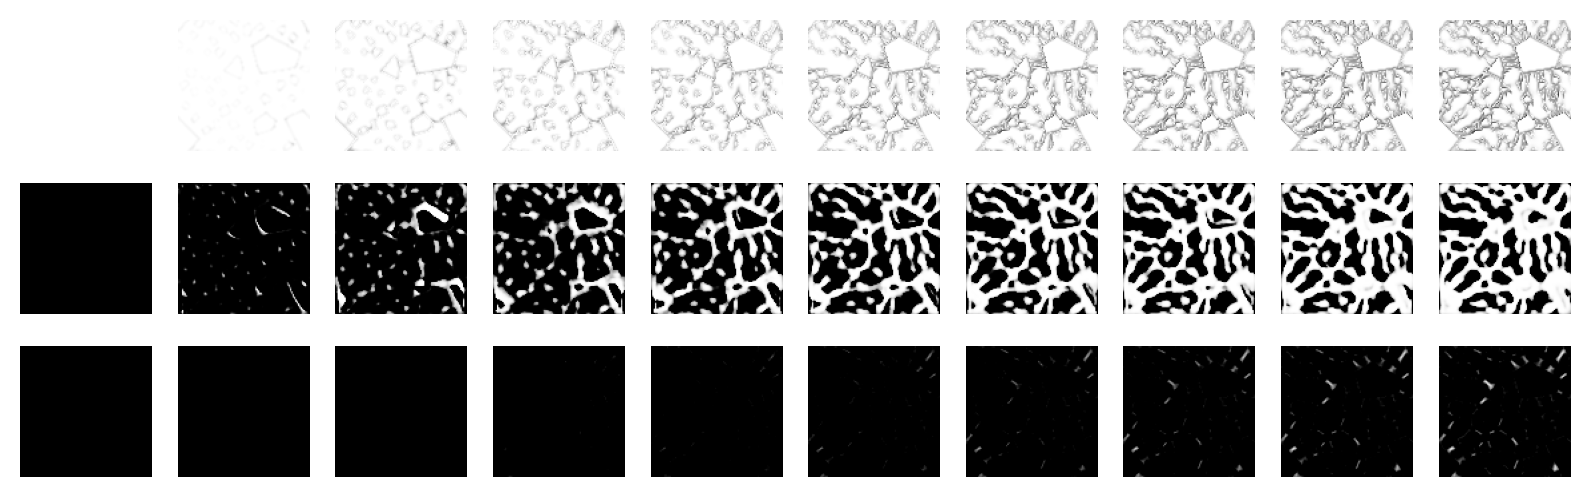

In [38]:
n_samples = 10
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples, 3), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow(np.abs((seq_test_dam[i]-damage[0, i].cpu()).detach().cpu().numpy()), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_stiff[i-n_samples].cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(2*n_samples, 3*n_samples):
    axs.flat[i].imshow(seq_test_shr[i-2*n_samples].cpu().numpy(), cmap='Greys', vmin=-1.5, vmax=0)
    axs.flat[i].set_axis_off()

In [35]:
print(seq_test_shr[9].min())

tensor(-1.2488)


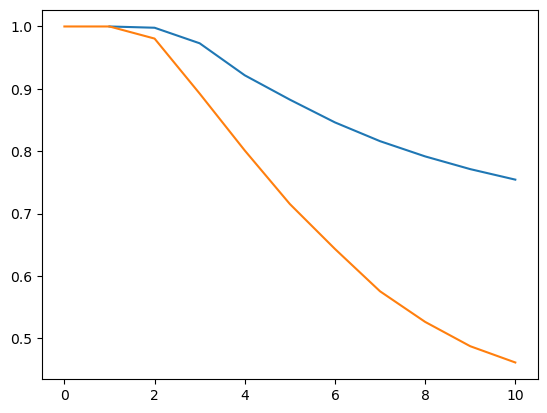

In [16]:
stiffness_mean = np.array([np.array(im) for im in seq_test_stiff])
plt.plot(np.arange(1,11),stiffness_mean.mean((1,2)))
plt.plot(stiffness[0].cpu() / stiffness[0,0].cpu())

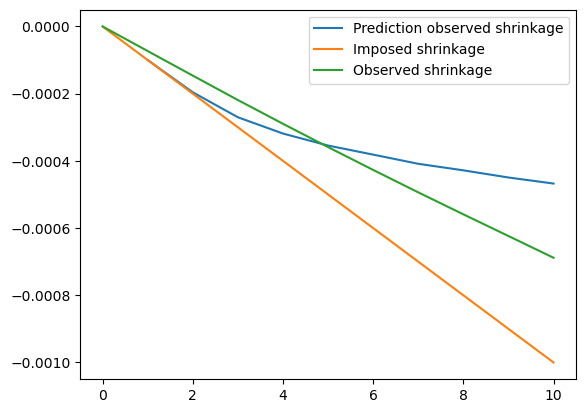

In [17]:
shr_mean = np.array([np.array(im) for im in seq_test_shr])
plt.plot(np.arange(1,11), (shr_mean.mean((1,2)) * imp_shrinkage[0,1:,0,0].cpu().numpy()))
plt.plot(imp_shrinkage.cpu().numpy().mean((0,2,3)))
plt.plot(obs_shrinkage[0].cpu().numpy())
plt.legend(['Prediction observed shrinkage', 'Imposed shrinkage', 'Observed shrinkage'])

Extrapolate

In [10]:
for n in range(10):
    x = torch.cat([geometry, imp_shrinkage[:,[9],:,:] - (n+1)*1e-4, y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach())
    seq_test_shr.append(y[0,1].detach())

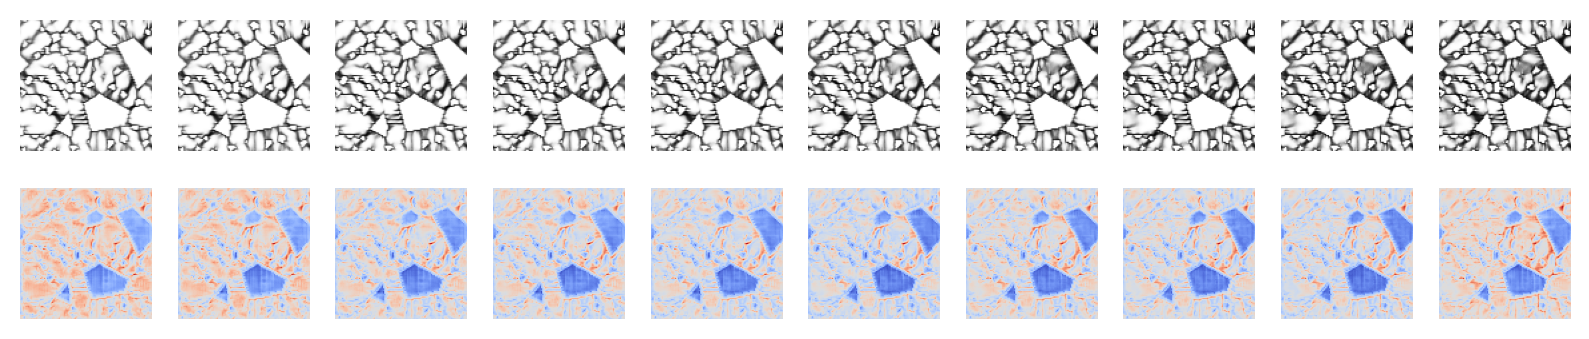

In [11]:
n_samples = 10
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i+n_samples]).detach().cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i].cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()

Skip

In [12]:
geometry, damage, imp_shrinkage, obs_shrinkage = next(iter(loaders['test']))
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
obs_shrinkage = obs_shrinkage.to(args['dev'])

In [17]:
seq_test_dam = []
seq_test_shr = []

for n in range(0,10,3):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:], damage[:,[n],:,:]], axis=1)
    else:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach())
    seq_test_shr.append(y[0,1].detach())

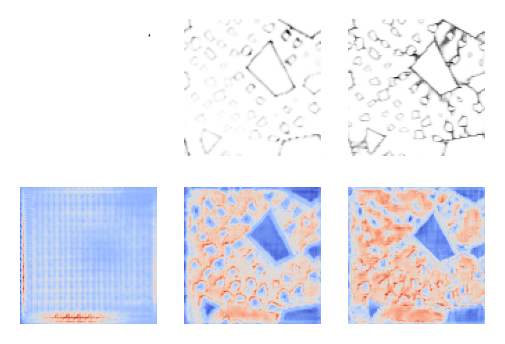

In [18]:
n_samples = 3
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i]).detach().cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i-n_samples].cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()